In [1]:
import os
import torch
import cv2

import matplotlib.pyplot as plt
import numpy as np

from bs4 import BeautifulSoup
from PIL import Image

In [ ]:
# If using Intel Arc GPU (like I am), run this cell.
import intel_extension_for_pytorch as ipex

In [2]:
DATA_ROOT_PATH = os.path.join("../", "guide3d/data/guide3d")
ANNOTATION_FILE_PATH = os.path.join(DATA_ROOT_PATH, "annotations.xml")

In [3]:
with open(ANNOTATION_FILE_PATH, 'r') as f:
    xml_data = f.read()

xml_parsed = BeautifulSoup(xml_data, "lxml")

In [4]:
# For testing, read some arbitrary image.
# some_img = os.path.join(DATA_ROOT_PATH, xml_parsed.camera["image"])
some_img = os.path.join(DATA_ROOT_PATH, "1-bca-straight-1-2", "241.png")
some_img = Image.open(some_img)

some_img.size

(1024, 1024)

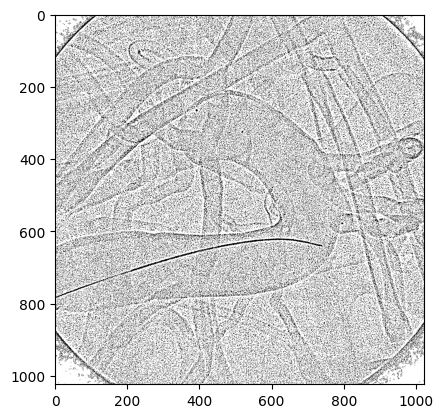

In [5]:
edges = cv2.adaptiveThreshold(np.array(some_img), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
 cv2.THRESH_BINARY, 11, 2)

plt.imshow(edges, cmap = "gray", vmin = 0, vmax = 255)


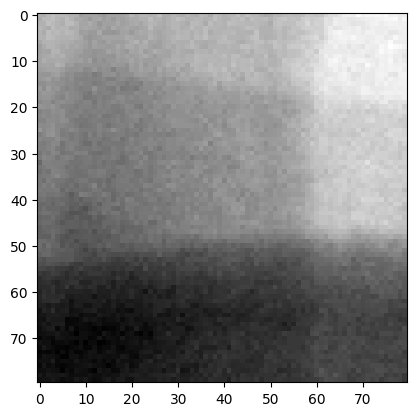

In [6]:
plt.imshow(np.array(some_img)[592-40:592+40, 192-40:192+40], cmap = "gray")

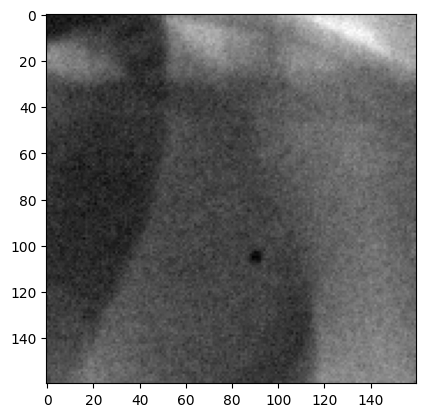

In [7]:
plt.imshow(np.array(some_img)[301-80:301+80, 508-80:508+80], cmap = "gray")

In [8]:
images = np.array([])


camera_xml_nodes = xml_parsed.findAll("camera")
reconstruction_xml_nodes = xml_parsed.findAll("reconstruction")

for each_camera_node in camera_xml_nodes:
    mask = np.zeros((1024, 1024))
    images = np.append(images, each_camera_node["image"])

print(images[2])


1-bca-angle-5-1/001.png


In [9]:
mask = np.zeros((1024, 1024))
x = np.array([])
y = np.array([])

for i in range(len(each_camera_node["points"].split(';'))):
    j, k = each_camera_node["points"].split(';')[i].split(',')
    print(k, j)

    x = np.append(x, int(j))
    y = np.append(y, int(k))

    mask[int(k)][int(j)] = 1
    

642 737
639 729
637 720
635 711
633 701
631 692
629 683
627 673
625 659
624 644
623 628
622 605
624 582
627 559
630 531
636 494
651 422
669 346
689 276
712 207
746 105
770 38
784 0


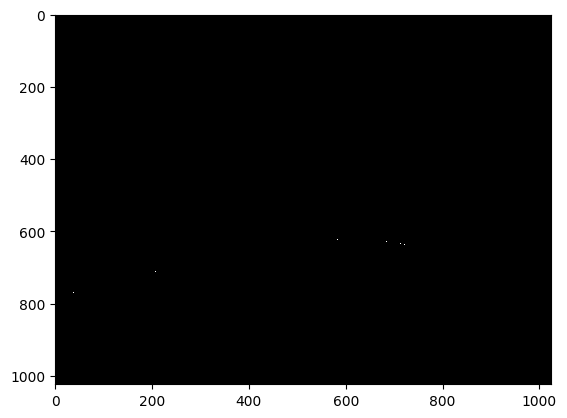

In [10]:
plt.imshow(np.array(mask), interpolation = "nearest", aspect = "auto", cmap = "gray")

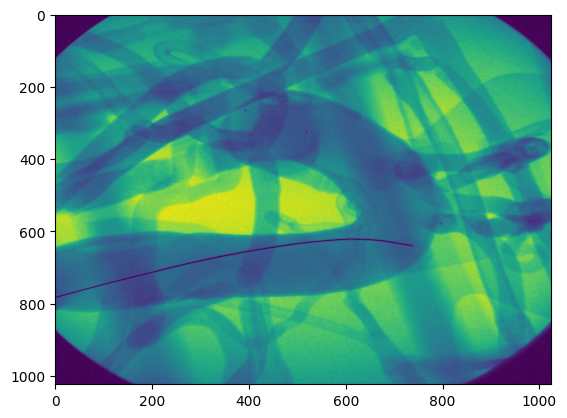

In [11]:
plt.imshow(np.array(some_img), interpolation = "nearest", aspect = "auto")
# plt.scatter(x, y, color = "red")

# Morph points into a polyline.

x = np.int32(x)
y = np.int32(y)

mask_points = np.concatenate([x[:,None], y[:,None]], axis = 1)
mask_points = mask_points.reshape((-1, 1, 2))

closed_img = cv2.polylines(np.array(some_img), [mask_points], isClosed = False, color = (0, 0, 255), thickness = 2)

plt.imshow(closed_img, aspect = "auto")

### Image Training for Segmentation

In [12]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch import nn
from torch.optim import SGD

from torchsummary import summary

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

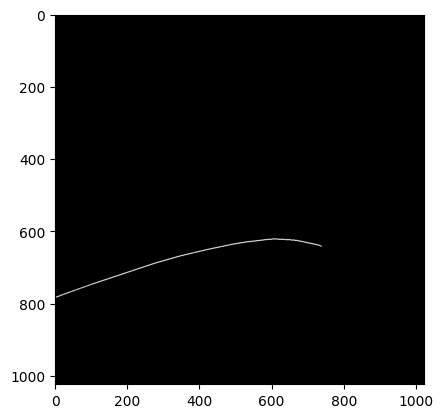

In [13]:
mask_points = np.subtract(closed_img, np.array(some_img))
plt.imshow(mask_points, cmap = "gray")

In [14]:
def GetImagesList():
    images = np.array([])

    camera_xml_nodes = xml_parsed.findAll("camera")

    for each_camera_node in tqdm(camera_xml_nodes):
        curr_img = each_camera_node["image"]
        images = np.append(images, curr_img)

    return images

def GetPoints(image_name):
    for each_camera_node in xml_parsed.findAll("camera"):
        if (each_camera_node["image"] == image_name):
            return each_camera_node["points"]

        # x = np.array([])
        # y = np.array([])
        
        # for i in range(len(each_camera_node["points"].split(';'))):
        #     j, k = each_camera_node["points"].split(';')[i].split(',')

        #     x = np.append(x, np.int32(j))
        #     y = np.append(y, np.int32(k))

    #     mask_points = np.concatenate([x[:,None], y[:,None]], axis = 1)
    #     mask_points = mask_points.reshape((-1, 1, 2))
    #     mask_points = np.int32(mask_points)

    #     # For the purpose of forming a polyline, we need to get the image data.

    #     tmp_img = os.path.join(DATA_ROOT_PATH, curr_img)
    #     tmp_img = np.array(Image.open(tmp_img), np.int32)

    #     closed_img = cv2.polylines(tmp_img, [mask_points], isClosed = False, color = (0, 0, 255), thickness = 2)
    #     segm = np.subtract(closed_img, tmp_img)

    #     print(segm.shape)
    #     break

In [15]:
a = GetImagesList()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8200/8200 [00:00<00:00, 8760.71it/s]


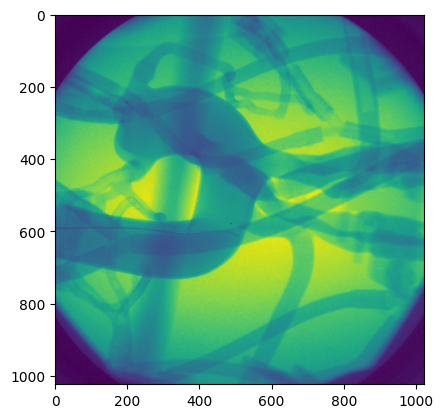

In [16]:
test_img = Image.open(os.path.join(DATA_ROOT_PATH, a[1000]))

plt.imshow(np.array(test_img))



In [17]:
class SegmDataLoader(Dataset):
    def __init__(self, transform = None, target_transform = None):
        self.images = GetImagesList()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # We return both the image matrix and segmentation matrix.
        points = GetPoints(self.images[idx])

        x = np.array([])
        y = np.array([])
        
        for i in range(len(points.split(';'))):
            j, k = points.split(';')[i].split(',')

            x = np.append(x, np.int32(j))
            y = np.append(y, np.int32(k))

        mask_points = np.concatenate([x[:,None], y[:,None]], axis = 1)
        mask_points = mask_points.reshape((-1, 1, 2))
        mask_points = np.int32(mask_points)

        # For the purpose of forming a polyline, we need to get the image data.

        _tmp_img = os.path.join(DATA_ROOT_PATH, self.images[idx])
        _tmp_img = Image.open(_tmp_img)

        _closed_img = cv2.polylines(np.array(_tmp_img), [mask_points], isClosed = False, color = (255, 0, 0), thickness = 2)
        _segm = np.subtract(_tmp_img, _closed_img)

        _tmp_img = np.array(_tmp_img)
        _segm = np.where(_segm != 0, 1, 0)

        # Finally, ensure both _tmp_img and _segm are tensors of current dtype that can carry gradient information.
        _tmp_img = torch.tensor(_tmp_img, dtype = torch.float32)
        _segm = torch.tensor(_segm, dtype = torch.long)
        
        return self.images[idx], _tmp_img, _segm

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8200/8200 [00:00<00:00, 8533.84it/s]


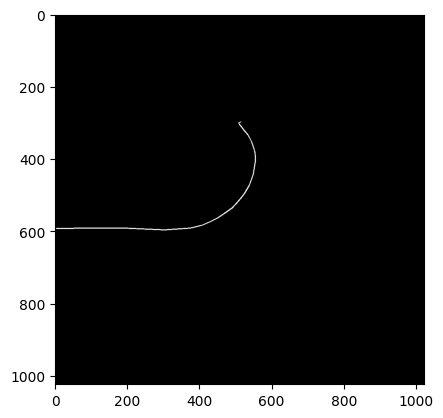

In [18]:
test_dl = SegmDataLoader()

for i in test_dl:
    _, tmp_img, segm = i

    plt.imshow(segm, cmap = "gray")

    break

In [25]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(1024*1024, 256)
        self.linear_2 = nn.Linear(256, 256)
        self.linear_3 = nn.Linear(256, 1024*1024)
        self.relu = nn.ReLU()
        self.lg_softmax = nn.LogSoftmax()

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        x = self.lg_softmax(x)

        return x

In [27]:
# del model
# import gc
# gc.collect()

model = Network().to("cuda")
print(model)

Network(
  (linear_1): Linear(in_features=1048576, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (linear_3): Linear(in_features=256, out_features=1048576, bias=True)
  (relu): ReLU()
  (lg_softmax): LogSoftmax(dim=None)
)


In [17]:
from torch.autograd import Variable

train_ds = SegmDataLoader()
train_dl = DataLoader(train_ds, batch_size = 124, shuffle = True, num_workers = 2)
loss_f = nn.NLLLoss().to("xpu")
TOTAL_EPOCHS = 3

losses = np.array([])
optimiser = SGD(model.parameters(), lr=0.00001)

print(model.parameters())

with torch.set_grad_enabled(True):
    torch.cuda.empty_cache()

    for epoch in range(TOTAL_EPOCHS):
        optimiser.zero_grad()
        curr_losses = np.array([])

        i = 0
        for single_data in tqdm(test_dl):
            _, tmp_img, segm = single_data
            tmp_img = tmp_img.reshape(-1).to("cuda")
            
            Y_preds = model(tmp_img)

            segm = segm.reshape(-1).to("cuda")

            loss = loss_f(Y_preds, segm)

            loss.backward()
            optimiser.step()

            curr_losses = np.append(curr_losses, loss.cpu().detach())

            losses = np.append(losses, np.mean(curr_losses))

            if i % 500 == 0:
                print("EPOCH MIN MAX", epoch, np.min(losses), np.max(losses))


            i += 1
        if epoch == 2:
            torch.save(model, "trained_model_3_epochs")
            torch.save(model.state_dict(), "trained_model_3_epochs_statedict")

            break

    del curr_losses

NameError: name 'SegmDataLoader' is not defined

### Testing

In [ ]:
model = torch.load("trained_model_3_epochs")

### U-Net Training

In [18]:
class SegmDataLoader(Dataset):
    def __init__(self, transform = None, target_transform = None):
        self.images = GetImagesList()[0:4000]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # We return both the image matrix and segmentation matrix.
        points = GetPoints(self.images[idx])

        x = np.array([])
        y = np.array([])
        
        for i in range(len(points.split(';'))):
            j, k = points.split(';')[i].split(',')

            x = np.append(x, np.int32(j))
            y = np.append(y, np.int32(k))

        mask_points = np.concatenate([x[:,None], y[:,None]], axis = 1)
        mask_points = mask_points.reshape((-1, 1, 2))
        mask_points = np.int32(mask_points)

        # For the purpose of forming a polyline, we need to get the image data.

        _tmp_img = os.path.join(DATA_ROOT_PATH, self.images[idx])
        _tmp_img = Image.open(_tmp_img)

        _closed_img = cv2.polylines(np.array(_tmp_img), [mask_points], isClosed = False, color = (255, 0, 0), thickness = 2)
        _segm = np.subtract(_tmp_img, _closed_img)

        _tmp_img = np.array(_tmp_img)
        _segm = np.where(_segm != 0, 1, 0)

        _tmp_img = (_tmp_img - _tmp_img.min())/(_tmp_img.max() - _tmp_img.min())


        _tmp_img = np.transpose(np.stack((_tmp_img,) * 3, axis = -1)).reshape(1, 3, 1024, 1024)
        _segm = np.transpose(_segm)
        # _segm = np.transpose(np.stack((_segm,) * 3, axis = -1)).reshape(1, 3, 1024, 1024)
        # Finally, ensure both _tmp_img and _segm are tensors of current dtype that can carry gradient information.
        _tmp_img = torch.tensor(_tmp_img, dtype = torch.float32)
        _segm = torch.tensor(_segm, dtype = torch.long)
        
        return self.images[idx], _tmp_img, _segm

In [3]:
import torch
import torch.nn as nn
from torchvision import models

from torch.utils.tensorboard import SummaryWriter

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load("./resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [20]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()

device = "cuda"
model = UNet(n_class=2)
model = model.to(device)

print(summary(model, input_size = (3, 1024, 1024)), device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]           1,792
              ReLU-2       [-1, 64, 1024, 1024]               0
            Conv2d-3       [-1, 64, 1024, 1024]          36,928
              ReLU-4       [-1, 64, 1024, 1024]               0
            Conv2d-5         [-1, 64, 512, 512]           9,408
            Conv2d-6         [-1, 64, 512, 512]           9,408
       BatchNorm2d-7         [-1, 64, 512, 512]             128
       BatchNorm2d-8         [-1, 64, 512, 512]             128
              ReLU-9         [-1, 64, 512, 512]               0
             ReLU-10         [-1, 64, 512, 512]               0
        MaxPool2d-11         [-1, 64, 256, 256]               0
        MaxPool2d-12         [-1, 64, 256, 256]               0
           Conv2d-13         [-1, 64, 256, 256]          36,864
           Conv2d-14         [-1, 64, 2

In [22]:
train_ds = SegmDataLoader()
loss_f = nn.CrossEntropyLoss().to("cuda")
TOTAL_EPOCHS = 50

losses = np.array([])
optimiser = SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser,T_max = 30)

tensorboard_writer = SummaryWriter()

print(model.parameters())

with torch.set_grad_enabled(True):
    torch.cuda.empty_cache()

    for epoch in range(TOTAL_EPOCHS):
        optimiser.zero_grad()
        curr_losses = np.array([])

        i = 0
        for single_data in tqdm(train_ds):
            _, tmp_img, segm = single_data
            tmp_img = tmp_img.to("cuda")
            
            Y_preds = model(tmp_img)

            # segm = segm.reshape(-1)
            segm = segm.reshape(1, 1024, 1024).to("cuda")

            # print(tmp_img.shape, segm.shape)

            loss = loss_f(Y_preds, segm)

            loss.backward()
            optimiser.step()
            scheduler.step()

            curr_losses = np.append(curr_losses, loss.cpu().detach())

            losses = np.append(losses, np.mean(curr_losses))

            if i % 500 == 0:
                tensorboard_writer.add_scalar("Loss/train", loss.cpu().detach(), epoch)
                print("EPOCH MIN MAX", epoch, np.min(losses), np.max(losses))


            i += 1
            
        torch.save(model, f"trained_model_{epoch}_epochs.pth")
        torch.save(model.state_dict(), f"trained_model_{epoch}_epochs_statedict.pth")

    del curr_losses

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8200/8200 [00:00<00:00, 8718.87it/s]


<generator object Module.parameters at 0x7ffeefb7e4a0>


  0%|                                                                                                                                                                        | 1/4000 [00:00<17:13,  3.87it/s]

EPOCH MIN MAX 0 0.7121188640594482 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [02:34<16:15,  3.59it/s]

EPOCH MIN MAX 0 0.21806556668630736 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [05:02<12:24,  4.03it/s]

EPOCH MIN MAX 0 0.1574528933159419 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [07:35<13:17,  3.13it/s]

EPOCH MIN MAX 0 0.11570065695330808 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [10:23<09:26,  3.53it/s]

EPOCH MIN MAX 0 0.09572407072535653 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [13:09<09:36,  2.60it/s]

EPOCH MIN MAX 0 0.08101633350599091 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [15:44<04:38,  3.58it/s]

EPOCH MIN MAX 0 0.0696975779257248 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [18:21<02:31,  3.29it/s]

EPOCH MIN MAX 0 0.06489774761976867 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:46,  4.51it/s]

EPOCH MIN MAX 1 0.0453256219625473 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:51<13:05,  4.45it/s]

EPOCH MIN MAX 1 0.0453256219625473 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:43<11:25,  4.37it/s]

EPOCH MIN MAX 1 0.0453256219625473 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:36<09:12,  4.53it/s]

EPOCH MIN MAX 1 0.0453256219625473 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:29<07:41,  4.33it/s]

EPOCH MIN MAX 1 0.0453256219625473 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:22<05:39,  4.41it/s]

EPOCH MIN MAX 1 0.0453256219625473 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:15<03:51,  4.31it/s]

EPOCH MIN MAX 1 0.044237606820763054 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:07<01:58,  4.23it/s]

EPOCH MIN MAX 1 0.04397635469329917 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:32,  4.58it/s]

EPOCH MIN MAX 2 0.041869089007377625 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:51<12:43,  4.58it/s]

EPOCH MIN MAX 2 0.041869089007377625 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:43<11:04,  4.51it/s]

EPOCH MIN MAX 2 0.041869089007377625 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:36<09:01,  4.62it/s]

EPOCH MIN MAX 2 0.041869089007377625 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:28<07:21,  4.53it/s]

EPOCH MIN MAX 2 0.041869089007377625 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:21<05:34,  4.48it/s]

EPOCH MIN MAX 2 0.041869089007377625 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:14<03:39,  4.55it/s]

EPOCH MIN MAX 2 0.04153350107706971 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:07<01:53,  4.41it/s]

EPOCH MIN MAX 2 0.04113510206488468 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:37,  4.56it/s]

EPOCH MIN MAX 3 0.03789396956562996 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:52<13:16,  4.39it/s]

EPOCH MIN MAX 3 0.03789396956562996 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:44<11:11,  4.47it/s]

EPOCH MIN MAX 3 0.03789396956562996 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:35<09:19,  4.46it/s]

EPOCH MIN MAX 3 0.03789396956562996 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:37<09:26,  3.53it/s]

EPOCH MIN MAX 3 0.03789396956562996 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:30<05:43,  4.36it/s]

EPOCH MIN MAX 3 0.03789396956562996 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:23<03:48,  4.38it/s]

EPOCH MIN MAX 3 0.037525196015085034 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:16<01:51,  4.49it/s]

EPOCH MIN MAX 3 0.03714128778231758 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<16:10,  4.12it/s]

EPOCH MIN MAX 4 0.03393731266260147 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:56<12:54,  4.52it/s]

EPOCH MIN MAX 4 0.03393731266260147 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:48<11:22,  4.40it/s]

EPOCH MIN MAX 4 0.03393731266260147 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:40<09:06,  4.57it/s]

EPOCH MIN MAX 4 0.03393731266260147 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:32<07:28,  4.45it/s]

EPOCH MIN MAX 4 0.03393731266260147 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:25<05:29,  4.56it/s]

EPOCH MIN MAX 4 0.03393731266260147 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:18<03:44,  4.45it/s]

EPOCH MIN MAX 4 0.03353149166236973 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:10<01:55,  4.33it/s]

EPOCH MIN MAX 4 0.03316191345155067 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:28,  4.61it/s]

EPOCH MIN MAX 5 0.029950473457574844 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:51<13:22,  4.36it/s]

EPOCH MIN MAX 5 0.029950473457574844 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:42<11:38,  4.29it/s]

EPOCH MIN MAX 5 0.029950473457574844 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:42<09:28,  4.39it/s]

EPOCH MIN MAX 5 0.029950473457574844 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:35<07:41,  4.33it/s]

EPOCH MIN MAX 5 0.029950473457574844 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:28<05:36,  4.45it/s]

EPOCH MIN MAX 5 0.029950473457574844 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:21<03:40,  4.53it/s]

EPOCH MIN MAX 5 0.029508225880476364 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:15<01:57,  4.26it/s]

EPOCH MIN MAX 5 0.029150299045319253 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<15:38,  4.26it/s]

EPOCH MIN MAX 6 0.025988126173615456 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:56<13:32,  4.30it/s]

EPOCH MIN MAX 6 0.025988126173615456 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:50<11:14,  4.44it/s]

EPOCH MIN MAX 6 0.025988126173615456 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:42<09:12,  4.52it/s]

EPOCH MIN MAX 6 0.025988126173615456 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:34<07:23,  4.51it/s]

EPOCH MIN MAX 6 0.025988126173615456 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:26<05:44,  4.35it/s]

EPOCH MIN MAX 6 0.025988126173615456 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:22<16:46,  1.01s/it]

EPOCH MIN MAX 6 0.025513869793747354 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:15<01:53,  4.38it/s]

EPOCH MIN MAX 6 0.02516953420384514 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<17:21,  3.84it/s]

EPOCH MIN MAX 7 0.02208476886153221 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:55<13:15,  4.40it/s]

EPOCH MIN MAX 7 0.02208476886153221 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:51<11:12,  4.46it/s]

EPOCH MIN MAX 7 0.02208476886153221 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:48<09:43,  4.28it/s]

EPOCH MIN MAX 7 0.02208476886153221 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:45<07:39,  4.35it/s]

EPOCH MIN MAX 7 0.02208476886153221 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:38<05:43,  4.36it/s]

EPOCH MIN MAX 7 0.02208476886153221 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:34<03:48,  4.37it/s]

EPOCH MIN MAX 7 0.021602935101234864 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:26<01:53,  4.41it/s]

EPOCH MIN MAX 7 0.021284585228624496 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:52,  4.48it/s]

EPOCH MIN MAX 8 0.018413538113236427 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:53<13:16,  4.39it/s]

EPOCH MIN MAX 8 0.018413538113236427 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:53<11:11,  4.46it/s]

EPOCH MIN MAX 8 0.018413538113236427 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:46<09:16,  4.49it/s]

EPOCH MIN MAX 8 0.018413538113236427 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:40<07:23,  4.51it/s]

EPOCH MIN MAX 8 0.018413538113236427 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:34<05:47,  4.31it/s]

EPOCH MIN MAX 8 0.018413538113236427 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:29<03:53,  4.28it/s]

EPOCH MIN MAX 8 0.0180503172227062 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:23<01:57,  4.24it/s]

EPOCH MIN MAX 8 0.017815743404621737 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:49,  4.50it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:53<13:16,  4.39it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:47<14:27,  3.46it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:41<09:26,  4.41it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:35<07:27,  4.46it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:30<05:36,  4.45it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:24<03:55,  4.24it/s]

EPOCH MIN MAX 9 0.015961308032274246 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:20<01:59,  4.19it/s]

EPOCH MIN MAX 9 0.01589739793802009 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<16:29,  4.04it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:59<12:50,  4.54it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:59<15:30,  3.22it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:59<09:31,  4.37it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:57<07:34,  4.40it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:57<05:49,  4.29it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:53<04:02,  4.12it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:48<01:51,  4.49it/s]

EPOCH MIN MAX 10 0.015604406595230103 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<15:16,  4.37it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:54<14:28,  4.03it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:47<11:22,  4.40it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:43<09:57,  4.18it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:36<07:31,  4.43it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:35<06:01,  4.14it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:33<03:40,  4.53it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:25<01:52,  4.42it/s]

EPOCH MIN MAX 11 0.015473521498635632 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:50,  4.49it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:58<13:57,  4.18it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [04:00<11:29,  4.35it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [06:10<09:25,  4.42it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [08:18<07:13,  4.62it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [10:14<05:56,  4.21it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [12:06<03:39,  4.56it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [14:00<01:59,  4.18it/s]

EPOCH MIN MAX 12 0.015473521498635632 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<34:23,  1.94it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:53<12:40,  4.60it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:48<11:16,  4.43it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:42<09:40,  4.30it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:36<09:40,  3.44it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:35<05:41,  4.38it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:32<03:49,  4.36it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:33<01:54,  4.36it/s]

EPOCH MIN MAX 13 0.01547288011306557 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<16:54,  3.94it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:56<13:39,  4.27it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:53<11:52,  4.21it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:46<09:05,  4.59it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:38<07:44,  4.31it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:30<05:32,  4.51it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:23<03:42,  4.49it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:20<01:54,  4.38it/s]

EPOCH MIN MAX 14 0.01547288011306557 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<14:46,  4.51it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:51<13:06,  4.45it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:45<11:18,  4.42it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:36<09:03,  4.60it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:30<07:53,  4.22it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:27<06:10,  4.05it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:23<03:50,  4.33it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:19<01:59,  4.17it/s]

EPOCH MIN MAX 15 0.01547288011306557 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<16:10,  4.12it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:52<13:32,  4.31it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [03:45<11:31,  4.34it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:38<11:28,  3.63it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:32<07:34,  4.40it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:26<05:29,  4.55it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:24<03:42,  4.49it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:17<01:56,  4.29it/s]

EPOCH MIN MAX 16 0.01547288011306557 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<16:51,  3.95it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [01:54<13:08,  4.44it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1002/4000 [03:46<10:29,  4.76it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [05:38<09:26,  4.41it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [07:31<07:51,  4.24it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2501/4000 [09:24<05:45,  4.34it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3001/4000 [11:21<04:14,  3.93it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3501/4000 [13:23<02:24,  3.45it/s]

EPOCH MIN MAX 17 0.01547288011306557 0.7121188640594482


  0%|                                                                                                                                                                        | 1/4000 [00:00<16:27,  4.05it/s]

EPOCH MIN MAX 18 0.01547288011306557 0.7121188640594482


 13%|████████████████████▊                                                                                                                                                 | 501/4000 [02:04<13:29,  4.32it/s]

EPOCH MIN MAX 18 0.01547288011306557 0.7121188640594482


 25%|█████████████████████████████████████████▎                                                                                                                           | 1001/4000 [04:09<11:01,  4.53it/s]

EPOCH MIN MAX 18 0.01547288011306557 0.7121188640594482


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1501/4000 [06:06<11:11,  3.72it/s]

EPOCH MIN MAX 18 0.01547288011306557 0.7121188640594482


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2001/4000 [08:19<08:48,  3.78it/s]

EPOCH MIN MAX 18 0.01547288011306557 0.7121188640594482


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2467/4000 [10:10<06:19,  4.04it/s]


KeyboardInterrupt: 

(1024, 1024)


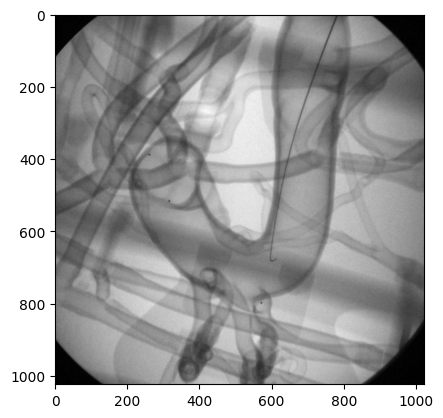

In [23]:
plt.imshow(tmp_img.cpu().detach().numpy()[0, 0, :, :], cmap = "gray")

print(tmp_img.cpu().detach().numpy()[0, 0, :, :].shape)

torch.Size([1024, 1024])


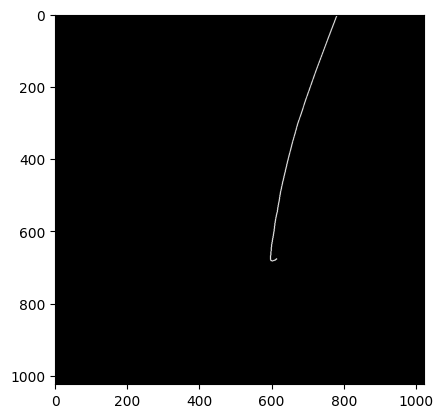

In [79]:
plt.imshow(segm.cpu().detach().numpy()[:, :], cmap = "gray")
print(segm.shape)

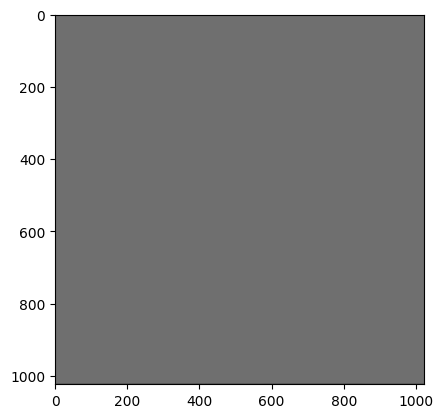

In [82]:
plt.imshow(torch.sigmoid(model(tmp_img)).cpu().detach().numpy()[0, 0, :, :], cmap = "gray")

In [4]:
size = 1024, 1024
m = UNet(n_class = 2)
m = torch.load("trained_model_1_epochs.pth")

test_img = Image.open("./TestImg.png").convert('L')

test_img = test_img.resize(size)
test_img = np.array(test_img, np.float32)

test_img = np.transpose(np.stack((test_img,) * 3, axis = -1)).reshape(1, 3, 1024, 1024)
plt.imshow(test_img[0, 0, :, :], cmap = "gray")

test_img = (test_img - test_img.min())/(test_img.max() - test_img.min())

print(np.min(test_img), np.max(test_img))

test_img = torch.tensor(test_img).reshape(1, 3, 1024, 1024).to("cuda")

Y_preds = m(test_img).cpu().detach()
print(Y_preds.shape)

ModuleNotFoundError: No module named 'model_mobile_unet'

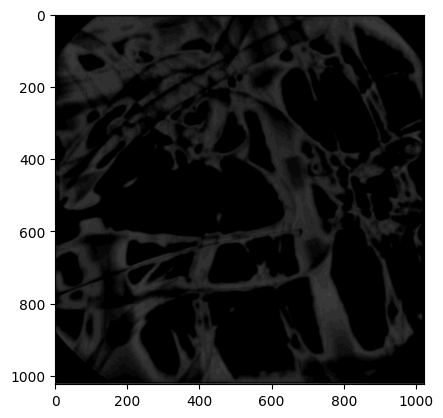

In [252]:
Y = torch.sigmoid(Y_preds).cpu().detach().numpy()

plt.imshow(Y[0, 0, :, :], cmap = "gray")

In [246]:
Y[0, 0, :, :]

array([[0.9999274 , 0.9999256 , 0.9999249 , ..., 0.9999244 , 0.99992454,
        0.99992454],
       [0.9999279 , 0.9999249 , 0.9999244 , ..., 0.9999244 , 0.9999244 ,
        0.9999244 ],
       [0.9999279 , 0.9999248 , 0.9999244 , ..., 0.9999244 , 0.9999244 ,
        0.9999244 ],
       ...,
       [0.999928  , 0.999925  , 0.9999244 , ..., 0.9999244 , 0.9999244 ,
        0.9999244 ],
       [0.9999281 , 0.9999255 , 0.99992454, ..., 0.9999244 , 0.9999244 ,
        0.9999244 ],
       [0.99992824, 0.9999273 , 0.9999267 , ..., 0.9999263 , 0.99992645,
        0.9999255 ]], dtype=float32)

255